In [1]:
import json
import os
import matplotlib.pyplot as plt
import pandas as pd
import glob
import numpy as np
from sklearn.metrics import mean_absolute_error
from matplotlib.ticker import ScalarFormatter
import statistics as stat

import proxima_analysis as pa

from IPython.core.display import display, HTML
display(HTML('<style>.container { width:100% !important; }</style>'))

BIG    = 22
MEDIUM = 20
FIGWIDTH=12
width = 0.25  # the width of the bars

XLINE  = 523.21
YLINE  = 0.002

colors = ['#E27100', '#1b85b8', '#559e83', '#b26167']

# Starting to define standardized colors
MAE_COLOR =colors[1]
TIME_COLOR=colors[0]

FIXED_COLOR  = 'tbd'
STATIC_COLOR = 'tbd'
DYNAMIC_COLOR= 'tbd'

FIXED_MARKER='tbd'
STATIC_MARKER='tbd'
DYNAMIC_MARKER='tbd'

In [2]:
experiments = [
    'NORT-Proxima_dynamicalpha', #Proxima - dynamic alpha with no retrain interval
    'NORT-Proxima_static-alpha', #Proxima - precalcualted alpha, no retrain interval
    'surrogate_only', ## Simple surrogate implementation
    'SS-UQ02-NORT_staticalpha', # Simple surrogate, uq:0.2, no retrain interval
    'DA_RT50', ## Proxima - dynamica alpha, testing single RT interval of 50 
    'DAallUQ_TEMP1000', ## Proxima - testing different retrain intervals and UQ's
    'SST1000_bestparameters', ## Simple surrogate - with different Retrain intervals tested
    'SS_RI300', ## Simple Surrogate with RI 300
    'SS-UQ02_I50', ## Simple surrogate, uq: 0.2, All temps, RI: 50
    'SS-UQall_I50', ## Simple surrogate,, all UQ, Temp: 500, RI: 50
    'surrogate-all_params', ## Simple surrogate, all uq, 500,1000K, RI: 1,50(for 500K), 100,500(1000K)
    'dyn_nostreak', ##Proxima - dynamic alpha, no surrogate streak option
    'SS-500k_allparams', ## Simple surrogate, all uq, 500k, RI: 1,50, 100-500
    
]
root_path = '../proxima_data'

# 1) Scatter Plot Method Comparison

## Loading HF Results

In [3]:
#root_path_hf = '/home/yzamora/proxima/examples/molecule-sampling'
path_str = '/'.join([root_path,'runtime_s1_data.csv'])
hf_times = pd.read_csv(path_str)

results = {n: None for n in experiments}
for name in results:
    path_str = "/".join([root_path, name, "*"])
    path = glob.glob(path_str)
    uq_thresholds, int_list, total_time, uq_time, speed_up = pa.process_times(path,hf_times)
    time_df = pa.time_to_df(uq_time)
    speedup_df = pa.speedup_to_df(speed_up)
    mae_values = pa.process_mae(path)
    mae_df = pa.mae_to_df(mae_values)
    #results[name] = time_df.merge(mae_df, on=["uq", "interval","temperature"], how="inner")
    time_mae = time_df.merge(mae_df, on=["uq", "interval","temperature"], how="inner")
    results[name]=speedup_df.merge(time_mae, on=["uq", "interval","temperature"], how="inner")

## Graphing HF time against temperature

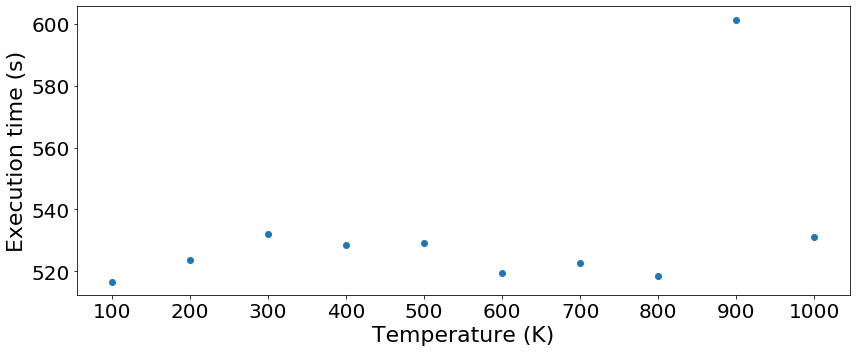

In [4]:
plt.subplots(figsize=(FIGWIDTH,5))
plt.plot(hf_times['Temp[K]'], hf_times['Runtime[s]'], 'o')

plt.xlabel('Temperature (K)', fontsize=BIG)
plt.ylabel('Execution time (s)', fontsize=BIG)
plt.xticks(hf_times['Temp[K]'])
plt.xticks(fontsize=MEDIUM)
plt.yticks(fontsize=MEDIUM)
plt.tight_layout()
plt.savefig('Figures/TF_times.pdf')

## Graphing MAE VS Time results of surrogate implementation
### A) Original plot_cases

In [5]:
def _plot_cases(cases):
    fig, ax = plt.subplots(figsize=(FIGWIDTH,5))
    for case in cases:
        df     = case.get('df')
        x      = case.get('x')
        y      = case.get('y')
        t      = case.get('t', None)
        s      = case.get('s', 36)
        color  = case.get('color', 'Black')
        label  = case.get('label', None)
        marker = case.get('marker', 'o')
        minor  = case.get('minor', False)
        legend = case.get('legend', True)
        # Following change is so that we can have hollow markers, which are easier to see when overlapping
        data = [(x,y) for (x,y) in zip(df[x], df[y])]
        my_x, my_y = zip(*data)
        plt.scatter(x=my_x, y=my_y, color=color, label=label, facecolors='none', marker=marker, s=s)
        if t!=None:
            data   = [(x,y,t) for (x,y,t) in zip(df[x], df[y], df[t])]
            for x, y, t in data:
                ax.annotate(t, (x, y+0.0002), rotation=90)

    ax.set_ylim([0.0, 0.009])
    ax.set_xscale('log')
    ax.ticklabel_format(axis='y', style='scientific', scilimits=(0,0), useMathText=True)
    ax.xaxis.set_major_formatter(ScalarFormatter())
    ax.tick_params(which='major', length=7, width=2)
    ax.tick_params(which='minor', length=4, width=1.5)
    if minor:
        ax.xaxis.set_minor_formatter(ScalarFormatter())
        for tick in ax.xaxis.get_minor_ticks():
            tick.label.set_fontsize(MEDIUM) 
    ax.axvline(x=XLINE, color=TIMECOLOR, linewidth=1)
    ax.axhline(y=0.002, color=MAECOLOR,  linewidth=1)
    plt.xlabel('Execution time',      fontsize=BIG)
    plt.ylabel('Mean absolute error', fontsize=BIG)
    plt.xticks(fontsize=MEDIUM)
    plt.yticks(fontsize=MEDIUM)
        
    ax.yaxis.get_offset_text().set_fontsize(MEDIUM)
    if legend:
        ax.legend(fontsize=BIG, markerscale=2)
    plt.tight_layout()

### B) Modified plot_cases

In [6]:
def _plot_cases_adapted(cases): #df_a, df_b, df_c, df_d):
    fig, ax = plt.subplots(figsize=(FIGWIDTH,5))
    for case in cases:
        df     = case.get('df')
        x      = case.get('x')
        y      = case.get('y')
        
        good   = [(x,y,t,i) for (x,y,t,i) in zip(df[x], df[y], df['uq'], df['interval']) if x < XLINE and y < YLINE]
        hiTime = [(x,y) for (x,y) in zip(df[x], df[y]) if x >= XLINE]
        hiMAE  = [(x,y) for (x,y) in zip(df[x], df[y]) if x < XLINE and y >= YLINE]
        good_x, good_y, _, _ = zip(*good)
        hiTime_x, hiTime_y   = zip(*hiTime)
        hiMAE_x, hiMAE_y     = zip(*hiMAE)
        plt.scatter(x=good_x,   y=good_y,   color='g',       facecolors='none', marker='s', s=36)
        plt.scatter(x=hiMAE_x,  y=hiMAE_y,  color=colors[1], facecolors='none', marker='v', s=36)
        plt.scatter(x=hiTime_x, y=hiTime_y, color=colors[0], facecolors='none', marker='o', s=36)
        # Customized position code. But then the whole function is customized...
        for x, y, t, i in good:
            if t==0.2:
                if i==50:
                    ax.annotate(f'{t}, {i}', (x-110, y-0.0005), color='green', fontsize=12)
                else:
                    ax.annotate(f'{t}, {i}', (x-95, y-0.0005), color='green', fontsize=12)
            else:
                ax.annotate(f'{t}, {i}', (x-50, y-0.0005), color='green', fontsize=12)

    ax.set_ylim([0.0, 0.009])
    ax.set_xscale('log')
    ax.ticklabel_format(axis='y', style='scientific', useMathText=True, scilimits=(0,0))
    ax.xaxis.set_major_formatter(ScalarFormatter())
    ax.tick_params(which='major', length=7, width=2)
    ax.tick_params(which='minor', length=4, width=1.5)
    ax.axvline(x=XLINE, color=TIMECOLOR, linewidth=1)
    ax.axhline(y=0.002, color=MAECOLOR,  linewidth=1)
    
    plt.xlabel('Execution time',      fontsize=BIG)
    plt.ylabel('Mean absolute error', fontsize=BIG)
    plt.xticks(fontsize=MEDIUM)
    plt.yticks(fontsize=MEDIUM)
    ax.yaxis.get_offset_text().set_fontsize(MEDIUM)
    
    #plt.text(560,   0.0072, 'Baseline time', rotation=90, color=colors[0], fontsize=BIG-1)
    plt.text(560,   0.0032, 'Baseline time', rotation=90, color=TIMECOLOR, fontsize=BIG)
    plt.text(13000, 0.0023, 'Target MAE',                 color=MAECOLOR, fontsize=BIG)
    
    plt.text(50,    0.0008, 'N='+str(len(good_x)),     color='g',       fontsize=BIG)
    plt.text(250,   0.007,  'N='+str(len(hiMAE_x)),    color=colors[1], fontsize=BIG)    
    plt.text(10000, 0.0008, 'N='+str(len(hiTime_x)), color=colors[0], fontsize=BIG)
    
    plt.scatter([XLINE], [0], color='r', marker='o', s=36, clip_on=False)
    #plt.scatter([441.544], [0.001595],   color='r', marker='o', facecolors='none', linewidths=2, s=60)
    

    from matplotlib.lines import Line2D
    custom_lines = [Line2D([0], [0], marker='s', markersize=10,  markerfacecolor='none', color='g',       lw=0),
                    Line2D([0], [0], marker='v', markersize=10,  markerfacecolor='none', color=colors[1], lw=0),
                    Line2D([0], [0], marker='o', markersize=10,  markerfacecolor='none', color=colors[0], lw=0),
                    Line2D([0], [0], marker='o', markersize=10,  color='r', lw=0)]
    ax.legend(custom_lines, ['Acceptable', 'MAE too high', 'Runtime too long', 'Target function only'], fontsize=BIG)

    plt.tight_layout()

In [7]:
#data = 'SS-500k_allparams'
data = 'surrogate-all_params'
r = results[data]
tg_time = 523.21
mae_target = 0.002
print(r[(r['time']<tg_time) & (r['mae']<mae_target) & (r['temperature']==500)])
df = results[data]
df2 = df[df['temperature']==500]
print(sorted(list(set(list(df2['uq'])))))

     uq  interval  temperature  speed_up     time       mae
46  0.2        50          500     1.154  458.786  0.000665
65  0.3        50          500     2.314  228.795  0.001788
[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]


In [8]:
r

,uq,interval,temperature,speed_up,time,mae
0,0.1,10,500,0.128,4147.923,0.000336
1,0.1,15,500,0.169,3128.879,0.000333
2,0.1,1,500,0.015,35905.520,0.000326
3,0.1,20,500,0.216,2449.619,0.000354
4,0.1,25,500,0.245,2162.476,0.000356
...,...,...,...,...,...,...
125,0.7,450,1000,8.653,61.376,0.006865
126,0.7,45,500,10.012,52.869,0.002649
127,0.7,500,1000,8.672,61.237,0.006865
128,0.7,50,500,10.715,49.402,0.014648


# Simple Surrogate Implementation
Results of tests with 
uq = 01.-0.7,
Temp=500
Retrain interval = 1,2,5-45(in intervals of 5)
Extreme RI 100-500

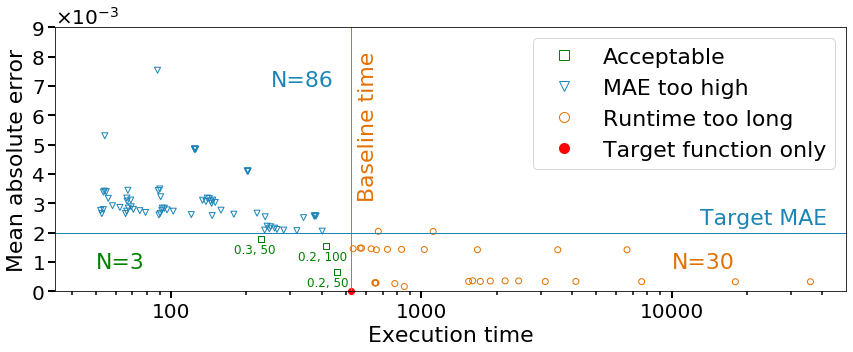

In [9]:
#df = results['surrogate-all_params']
df =results['SS-500k_allparams']
df2 = df[df['temperature']==500]
cases = (
        {'df': df2, 'x':'time', 'y':'mae', 'color':'Green', 'marker':'x'},
    )
_plot_cases_adapted(cases)
plt.savefig('Figures/ss_extremeparams.pdf')
plt.show()

## Simple Surrogate
Only retrain intervals from 1- 50

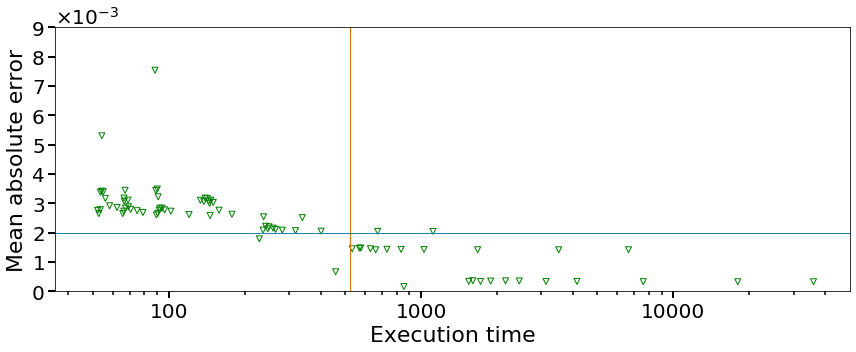

In [10]:
cases = (
        {'df': results['surrogate_only'], 'x':'time', 'y':'mae', 'color':'Green', 'marker':'v', 'legend':False},
    )
_plot_cases(cases)
plt.savefig('Figures/ss_allparams.pdf')

## Looking through all surrogate parameters

In [11]:
"""bs = results['SST1000_bestparameters']
bs[bs['interval']==400]
bs[bs['mae']<0.002]"""

"bs = results['SST1000_bestparameters']\nbs[bs['interval']==400]\nbs[bs['mae']<0.002]"

## SS implementation - No Retrain Interval
UQ=0.2 No retraining interval

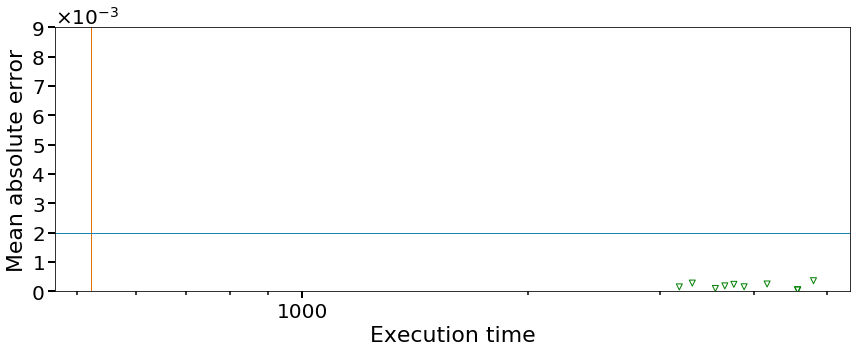

In [12]:
cases = (
        #{'df': results['SS-UQ02-NORT_staticalpha'], 'x':'time', 'y':'mae','t': 'temperature', 'color':'Green', 'marker':'x', 'legend':False},
        {'df': results['SS-UQ02-NORT_staticalpha'], 'x':'time', 'y':'mae', 'color':'Green', 'marker':'v', 'legend':False},
    )
_plot_cases(cases)
plt.savefig('Figures/ss_nort.pdf')

# Simple Surrogate Implementation VS Proxima -- NO RI
Results of tests with 
uq = 0.2
Retrain interval = No retrain interval specified

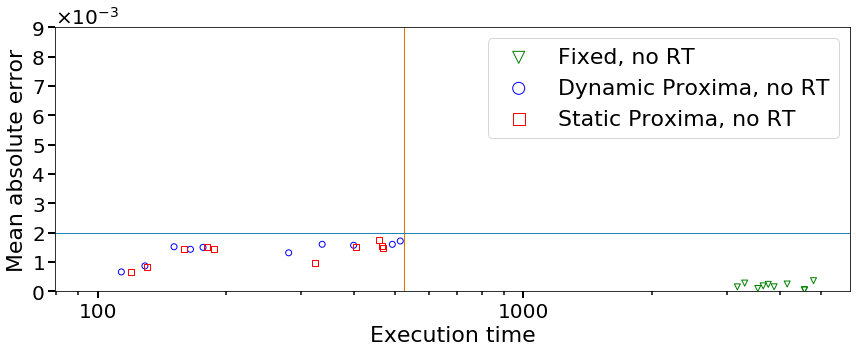

In [13]:
cases = (
        #{'df': results['SS-UQ02-NORT_staticalpha'],  'x':'time', 'y':'mae', 't': 'temperature', 'color':'Green', 'label':'Fixed, no RT',           'marker':'x'},
        #{'df': results['NORT-Proxima_dynamicalpha'], 'x':'time', 'y':'mae', 't': 'temperature', 'color':'Blue',  'label':'Dynamic Proxima, no RT', 'marker':'o'},
        #{'df': results['NORT-Proxima_static-alpha'], 'x':'time', 'y':'mae', 't': 'temperature', 'color':'REd',   'label':'Static Proxima, no RT',  'marker':'s'},
        {'df': results['SS-UQ02-NORT_staticalpha'],  'x':'time', 'y':'mae', 'color':'Green', 'label':'Fixed, no RT',           'marker':'v'},
        {'df': results['NORT-Proxima_dynamicalpha'], 'x':'time', 'y':'mae', 'color':'Blue',  'label':'Dynamic Proxima, no RT', 'marker':'o'},
        {'df': results['NORT-Proxima_static-alpha'], 'x':'time', 'y':'mae', 'color':'Red',   'label':'Static Proxima, no RT',  'marker':'s'},
    )
_plot_cases(cases)
plt.savefig('Figures/no_retrain.pdf')

## Simple Surrogate Implementation, best parameters- RI = 300
Results of tests with uq = 0.2 Retrain interval = 300

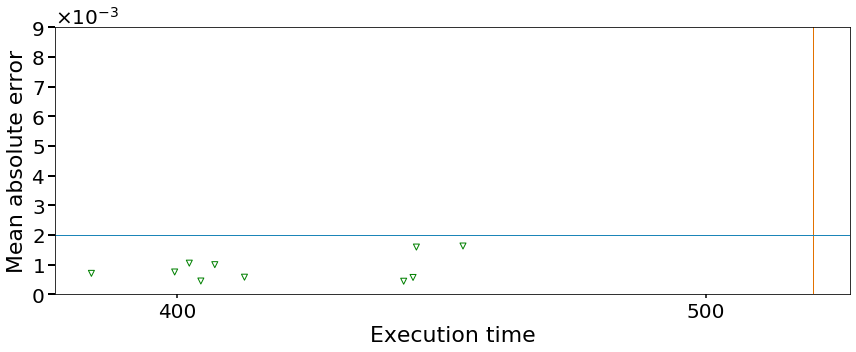

In [14]:
cases = (
        {'df': results['SS_RI300'], 'x':'time', 'y':'mae', 'color':'Green', 'marker':'v', 'minor':True, 'legend':False},
    )
_plot_cases(cases)
plt.savefig('Figures/ss_ri300.pdf')

## SS best parameters, RI=300 VS Proxima dynamic and static
UQ=0.2, RI=300

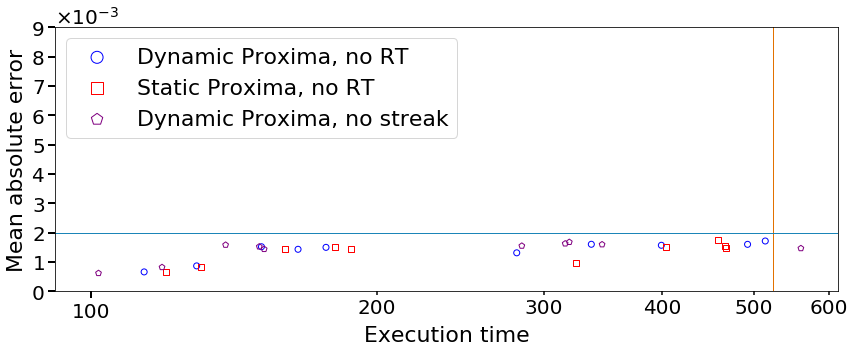

In [15]:
cases = (
        {'df': results['NORT-Proxima_dynamicalpha'], 'x':'time', 'y':'mae', 'color':'Blue', 'label':'Dynamic Proxima, no RT', 'marker':'o', 'minor':True},
        {'df': results['NORT-Proxima_static-alpha'], 'x':'time', 'y':'mae', 'color':'Red', 'label':'Static Proxima, no RT', 'marker':'s', 'minor':True},
        {'df': results['dyn_nostreak'], 'x':'time', 'y':'mae', 'color':'Purple', 'label':'Dynamic Proxima, no streak', 'marker':'p', 'minor':True},
        #{'df': results['SS_RI300'], 'x':'time', 'y':'mae', 'color':'Green', 'label':'Fixed with RI=300', 'marker':'v', 'minor':True},
    )
_plot_cases(cases)
plt.savefig('Figures/ThreeProx_scatter.pdf')

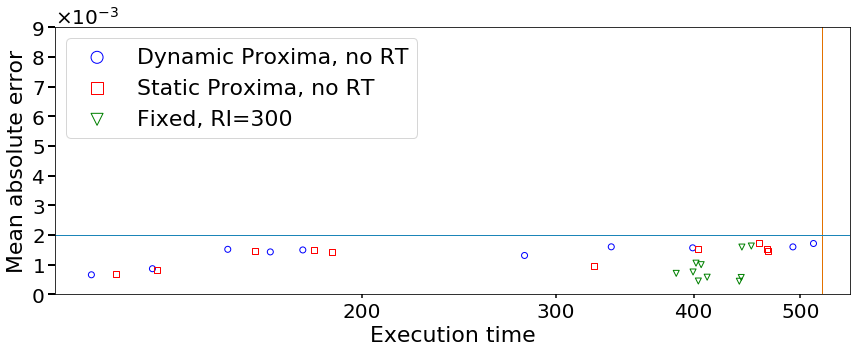

In [16]:
cases = (
        {'df': results['NORT-Proxima_dynamicalpha'], 'x':'time', 'y':'mae', 'color':'Blue', 'label':'Dynamic Proxima, no RT', 'marker':'o', 'minor':True},
        {'df': results['NORT-Proxima_static-alpha'], 'x':'time', 'y':'mae', 'color':'Red', 'label':'Static Proxima, no RT', 'marker':'s', 'minor':True},
        #{'df': results['dyn_nostreak'], 'x':'time', 'y':'mae', 'color':'Purple', 'label':'Dynamic Proxima, no streak', 'marker':'p', 'minor':True},
        {'df': results['SS_RI300'], 'x':'time', 'y':'mae', 'color':'Green', 'label':'Fixed, RI=300', 'marker':'v', 'minor':True},
    )
_plot_cases(cases)
#plt.savefig('Figures/ThreeProx_scatter.pdf')
plt.savefig('Figures/ssbest_prox.pdf') ## not including Dynamic Proxima without streak check

# Plotting other comparisons

## Dynamic VS Static VS Simple Surrogate 
No retrain interval for Proxima implementations 

Simple surrogate implementation results are of all UQ and RI combinations

'NORT-Proxima_dynamicalpha', 'NORT-Proxima_static-alpha', 'surrogate_only'

All temperatures for Proxima - 500K for surrogate

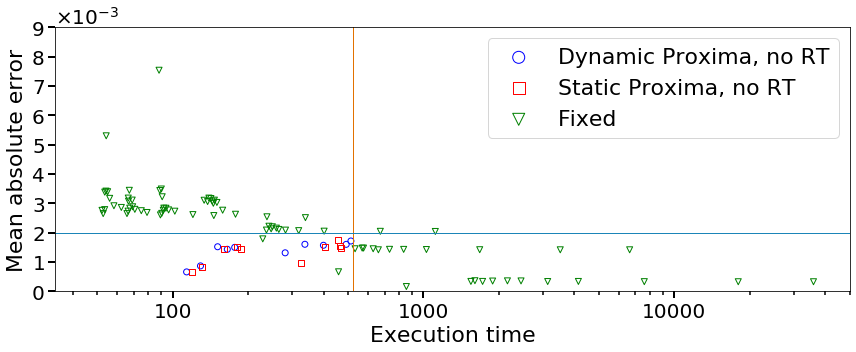

In [17]:
cases = (
        {'df': results['NORT-Proxima_dynamicalpha'], 'x':'time', 'y':'mae', 'color':'Blue', 'label':'Dynamic Proxima, no RT', 'marker':'o'},
        {'df': results['NORT-Proxima_static-alpha'], 'x':'time', 'y':'mae', 'color':'REd', 'label':'Static Proxima, no RT', 'marker':'s'},
        {'df': results['surrogate_only'], 'x':'time', 'y':'mae', 'color':'Green', 'label':'Fixed', 'marker':'v'},
    )
_plot_cases(cases)

## No retrain interval comparison - Tests across all temperatures
No retrain interval used on all methods
UQ = 0.2 for simple surrogate to keep under MAE for all temperatures
Temperatures of 100 - 1000K, in increments of 100 tested 

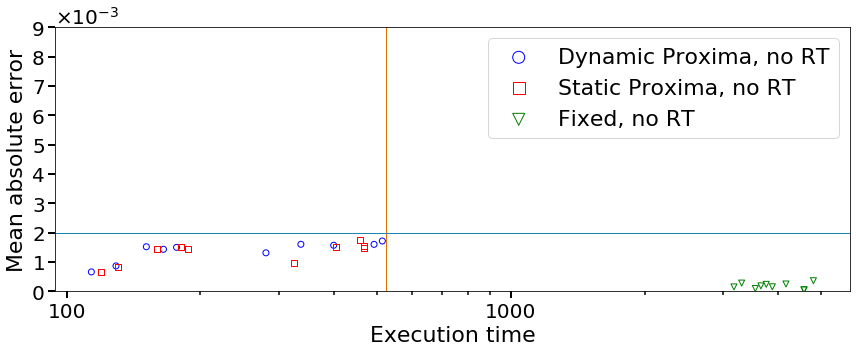

In [18]:
cases = (
        {'df': results['NORT-Proxima_dynamicalpha'], 'x':'time', 'y':'mae', 'color':'Blue', 'label':'Dynamic Proxima, no RT', 'marker':'o'},
        {'df': results['NORT-Proxima_static-alpha'], 'x':'time', 'y':'mae', 'color':'REd', 'label':'Static Proxima, no RT', 'marker':'s'},
        {'df': results['SS-UQ02-NORT_staticalpha'], 'x':'time', 'y':'mae', 'color':'Green', 'label':'Fixed, no RT', 'marker':'v'},
    )
_plot_cases(cases)

## Comparing Proxima implementations
Using Retrain Interval VS predetermined retrain interval

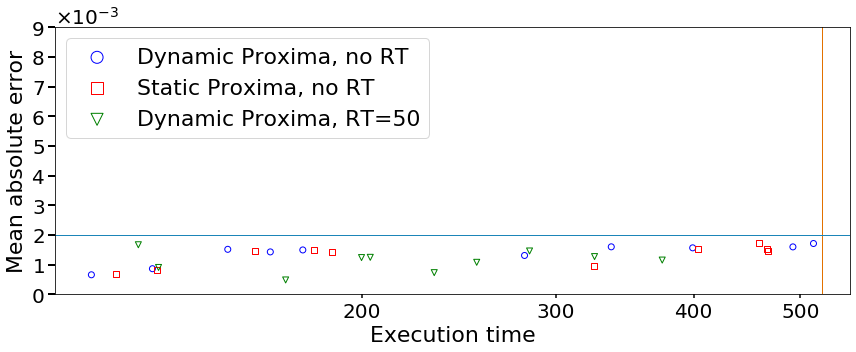

In [19]:

cases = (
        {'df': results['NORT-Proxima_dynamicalpha'], 'x':'time', 'y':'mae', 'color':'Blue', 'label':'Dynamic Proxima, no RT', 'marker':'o', 'minor':True},
        {'df': results['NORT-Proxima_static-alpha'], 'x':'time', 'y':'mae', 'color':'Red', 'label':'Static Proxima, no RT', 'marker':'s', 'minor':True},
        {'df': results['DA_RT50'], 'x':'time', 'y':'mae', 'color':'Green', 'label':'Dynamic Proxima, RT=50', 'marker':'v', 'minor':True},
    )
_plot_cases(cases)

## Dynamic Proxima compared with simple surrogate with RI 300

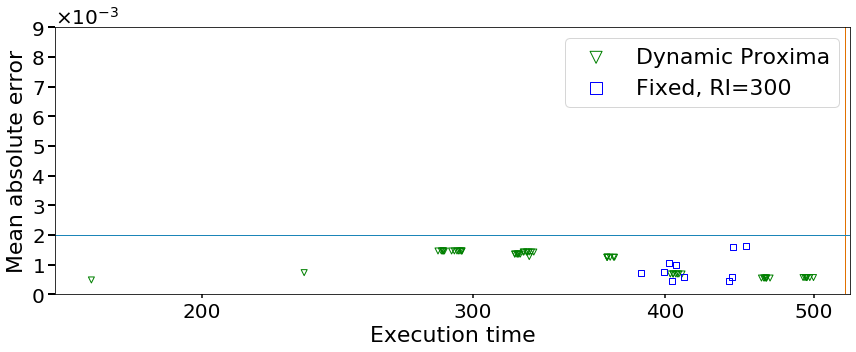

In [20]:
cases = (
        {'df': results['DAallUQ_TEMP1000'], 'x':'time', 'y':'mae', 'color':'Green', 'label':'Dynamic Proxima', 'marker':'v', 'minor':True},
        {'df': results['SS_RI300'], 'x':'time', 'y':'mae', 'color':'Blue', 'label':'Fixed, RI=300', 'marker':'s', 'minor':True},
    )
_plot_cases(cases)

## Mixed results  - Dynamic Proxima compared with simple surrogate
Dyanamic proxima is run using constant temperature (1,000K)

UQ = 0.1 - 0.7
Retrain Interval = 1,2,5-45,increments of 5
And Retrain Intervals = 100-500, increments of 50

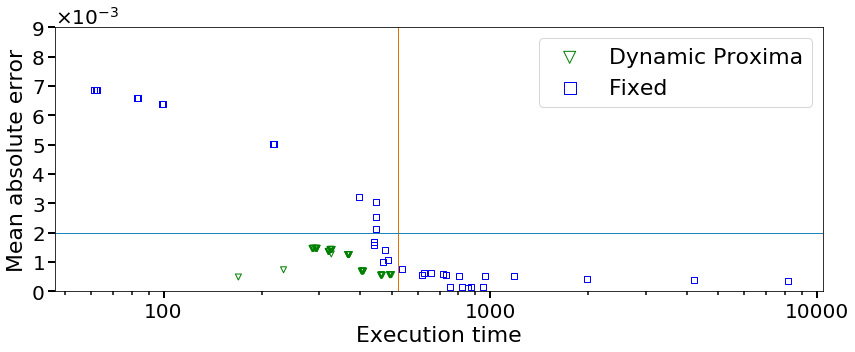

In [21]:
cases = (
        {'df': results['DAallUQ_TEMP1000'], 'x':'time', 'y':'mae', 'color':'Green', 'label':'Dynamic Proxima', 'marker':'v'},
        {'df': results['SST1000_bestparameters'], 'x':'time', 'y':'mae', 'color':'Blue', 'label':'Fixed', 'marker':'s'},
    )
_plot_cases(cases)

# 2) Energy computations

In [22]:
def get_true_run(true_energy, surrogate_energy_true, surrogate_energy_values):
    e_true = np.array(true_energy[0:])
    e_used = np.array(true_energy[0:])
    for s, e in zip(surrogate_energy_true['step'], surrogate_energy_values):
        e_used[s-1] = e
    return e_used

## Singular Energy trajectory Graph

In [23]:
def generate_energy_graph(kind):
    offset = -1081.0115
    if kind=='simple':
        app = "08Oct20-205633_p_0.003_uq_0.2_T_500_I_300_M_1" ## Can find single results in data directory
        results = pd.read_csv(root_path + "/SS_RI300/"+ app + "/tests_run_data.csv")
    else:
        app = "14Oct20-151642_p_0.003_uq_0.5_T_500_I_1_M_1" ## Can find single results in data directory
        results = pd.read_csv(root_path + "/NORT-Proxima_dynamicalpha/"+ app + "/tests_run_data.csv")

    fig, ax = plt.subplots(figsize=(FIGWIDTH,7))
    
    surrogate_energy_true = results[results['surrogate'] == True]
    surrogate_energy_values = surrogate_energy_true['surrogate_energy']
    new_energy = results[results['surrogate']== False]
    new_energy_val = new_energy['new_energy']
    true_energy = results['true_new_energy']

    plt.plot(results['step'], true_energy[0:]-offset, 'v', fillstyle='none', color=colors[0], markersize=5, label='True energy')
    plt.plot(surrogate_energy_true['step'], surrogate_energy_values-offset, 'o', fillstyle='none', color=colors[1], markersize=5, label='Surrogate energy')
    plt.plot(new_energy['step'], new_energy_val-offset, 's', markersize=5, fillstyle='none', color='g', label='Target energy')
    ax.ticklabel_format(axis='y', style='scientific', scilimits=(0,0), useMathText=True) # useOffset=False)
    #ax.ticklabel_format(axis='y',style='scientific',scilimits=(-3,3))
    plt.xticks(fontsize=MEDIUM)
    plt.yticks(fontsize=MEDIUM)
    ax.yaxis.get_offset_text().set_fontsize(MEDIUM)

    plt.ylabel('Relative energy', fontsize=BIG)
    plt.xlabel('Steps', fontsize=BIG)
    plt.legend(loc='upper left', fontsize=BIG, markerscale=2)
    plt.tight_layout()
    
    if kind=='simple':
        plt.savefig('Figures/SS_energy.pdf')
    else:
        plt.savefig('Figures/dyn_energy.pdf')

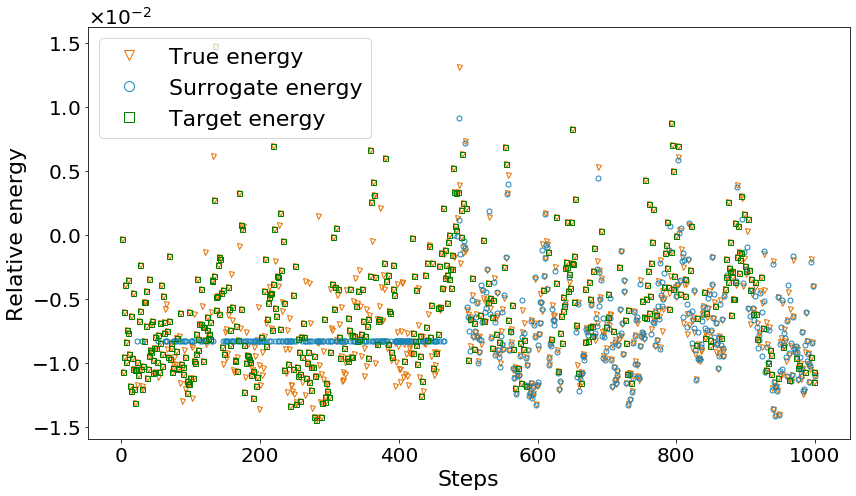

In [24]:
generate_energy_graph('simple')

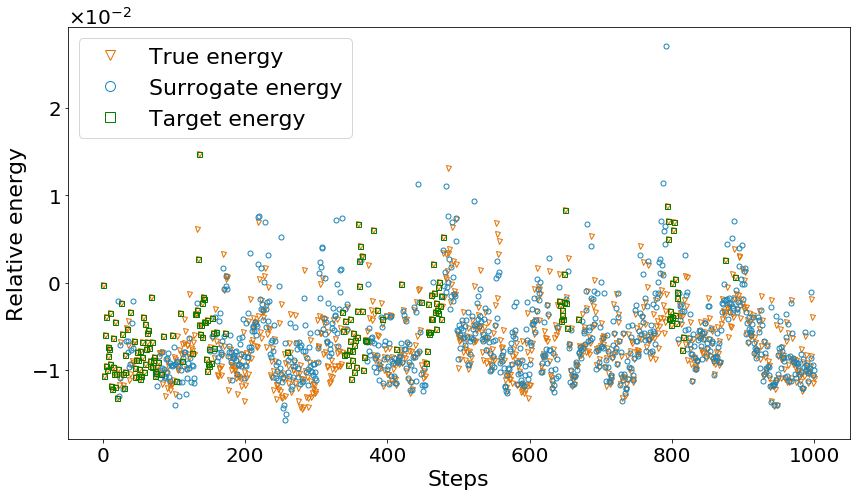

In [25]:
generate_energy_graph('other')

## Energy VS True Energy

In [26]:
def get_true_run(true_energy, surrogate_energy_true, surrogate_energy_values):
    e_true = np.array(true_energy[0:])
    e_used = np.array(true_energy[0:])
    for s, e in zip(surrogate_energy_true['step'], surrogate_energy_values):
        e_used[s-1] = e

    return e_used

def energy_vs_graph(kind):
    offset = -1081.0115
    if kind=='simple':
        app = "08Oct20-205633_p_0.003_uq_0.2_T_500_I_300_M_1" ## Can find single results in data directory
        results = pd.read_csv(root_path + "/SS_RI300/"+ app + "/tests_run_data.csv")
    else:
        app = "14Oct20-151642_p_0.003_uq_0.5_T_500_I_1_M_1" ## Can find single results in data directory
        results = pd.read_csv(root_path + "/NORT-Proxima_dynamicalpha/"+ app + "/tests_run_data.csv")

    fig, ax = plt.subplots(figsize=(FIGWIDTH,7))
    
    surrogate_energy_true = results[results['surrogate'] == True]
    surrogate_energy_values = surrogate_energy_true['surrogate_energy']
    new_energy = results[results['surrogate']== False]
    new_energy_val = new_energy['new_energy']
    true_energy = results['true_new_energy']
    #import pdb; pdb.set_trace()
    e_used = get_true_run(true_energy, surrogate_energy_true, surrogate_energy_values)
    plt.plot(true_energy[0:]-offset, e_used-offset, 'o', fillstyle='none', markersize=5)
    ax.ticklabel_format(axis='x', style='scientific', scilimits=(0,0), useMathText=True) # useOffset=False)
    ax.ticklabel_format(axis='y', style='scientific', scilimits=(0,0), useMathText=True) # useOffset=False)
    #ax.ticklabel_format(axis='y',style='scientific',scilimits=(-3,3))
    plt.xticks(fontsize=MEDIUM)
    plt.yticks(fontsize=MEDIUM)
    plt.ylim((-0.02,0.03))
    ax.yaxis.get_offset_text().set_fontsize(MEDIUM)
    ax.xaxis.get_offset_text().set_fontsize(MEDIUM)

    plt.ylabel('Energy', fontsize=BIG)
    plt.xlabel('True energy', fontsize=BIG)
    #plt.legend(loc='upper left', fontsize=BIG, markerscale=2)
    plt.tight_layout()
    
    if kind=='simple':
        plt.savefig('Figures/EnergyVS_SS.pdf')
    else:
        plt.savefig('Figures/EnergyVS_ProxD.pdf')
        
def plot_one(results, label, marker, color):
    offset = -1081.0115
    surrogate_energy_true = results[results['surrogate'] == True]
    surrogate_energy_values = surrogate_energy_true['surrogate_energy']
    new_energy = results[results['surrogate']== False]
    new_energy_val = new_energy['new_energy']
    true_energy = results['true_new_energy']
    e_used = get_true_run(true_energy, surrogate_energy_true, surrogate_energy_values)
    plt.plot(true_energy[0:]-offset, e_used-offset, marker, fillstyle='none', color=color, markersize=5, label=label, alpha=0.5)
        
def energy_vs_graph_both():
    app_simple = "08Oct20-205633_p_0.003_uq_0.2_T_500_I_300_M_1" ## Can find single results in data directory
    results_simple = pd.read_csv(root_path + "/SS_RI300/"+ app_simple + "/tests_run_data.csv")
    app_other = "14Oct20-151642_p_0.003_uq_0.5_T_500_I_1_M_1" ## Can find single results in data directory
    results_other = pd.read_csv(root_path + "/NORT-Proxima_dynamicalpha/"+ app_other + "/tests_run_data.csv")

    fig, ax = plt.subplots(figsize=(FIGWIDTH,7))
    
    plot_one(results_simple, 'Simple', 'o', colors[0])
    plot_one(results_other,  'Other',  'v', colors[1])

    ax.ticklabel_format(axis='x', style='scientific', scilimits=(0,0), useMathText=True) # useOffset=False)
    ax.ticklabel_format(axis='y', style='scientific', scilimits=(0,0), useMathText=True) # useOffset=False)
    #ax.ticklabel_format(axis='y',style='scientific',scilimits=(-3,3))
    plt.xticks(fontsize=MEDIUM)
    plt.yticks(fontsize=MEDIUM)
    plt.ylim((-0.02,0.03))
    ax.yaxis.get_offset_text().set_fontsize(MEDIUM)
    ax.xaxis.get_offset_text().set_fontsize(MEDIUM)

    plt.ylabel('Predicted energy', fontsize=BIG)
    plt.xlabel('True energy', fontsize=BIG)
    plt.legend(loc='upper left', fontsize=BIG, markerscale=2)
    plt.tight_layout()
    
    plt.savefig('Figures/EnergyVS_SS_ProxD.pdf')

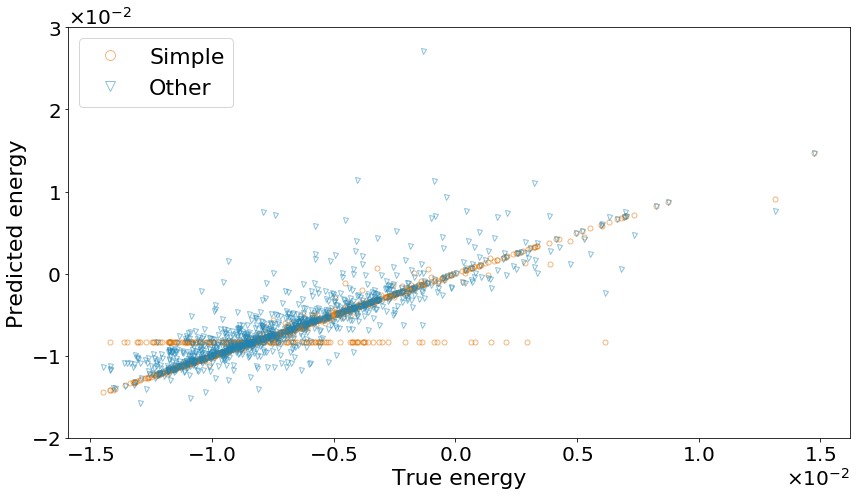

In [27]:
energy_vs_graph_both()

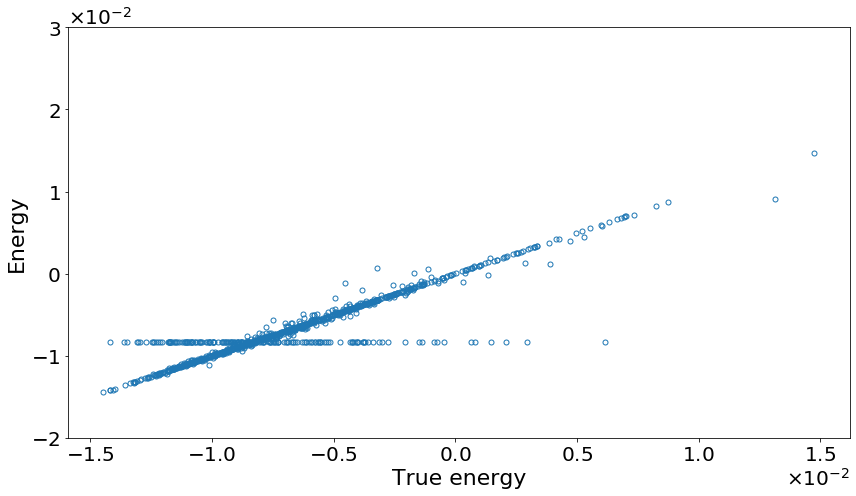

In [28]:
energy_vs_graph('simple')

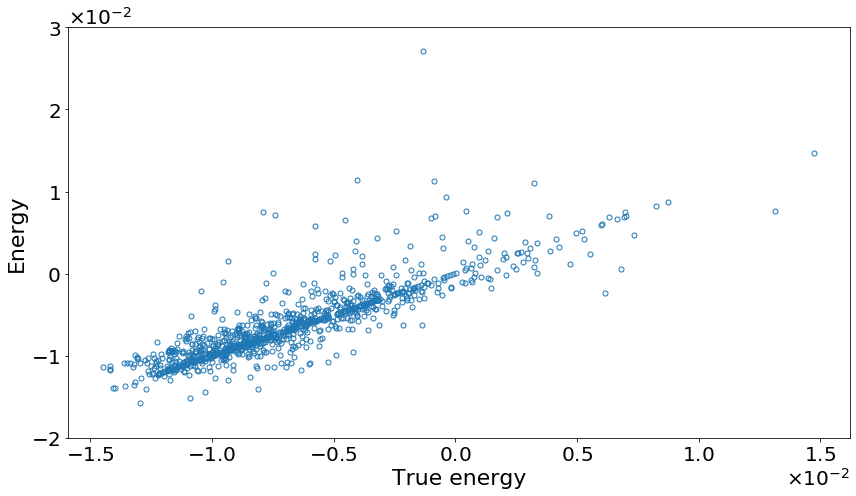

In [29]:
energy_vs_graph('other')

# 3) MAE Speedup Bar Charts

In [30]:
def graph_values(name):
    _t_sa = results[name]['time']
    _speedup_sa = results[name]['speed_up']
    _temp_sa = results[name]['temperature']
    _mae_sa = results[name]['mae']
   
    _temp_sa, _t_sa, _mae_sa = zip(*sorted(zip(_temp_sa, _t_sa,_mae_sa)))
    hm_mae_sa = stat.harmonic_mean(_mae_sa)
    hm_t_sa = stat.harmonic_mean(_t_sa)
    _mae_sa = _mae_sa + (hm_mae_sa,)
    _t_sa = _t_sa + (hm_t_sa,)
    _temp_sa = _temp_sa + ('HM',)
    return _mae_sa,_t_sa, _temp_sa
    
_mae_sa,_t_sa,_temp_sa = graph_values("NORT-Proxima_static-alpha")
_mae_da,_t_da,_temp_da = graph_values("NORT-Proxima_dynamicalpha")
_mae_ssnort,_t_ssnort, _temp_ssnort = graph_values("SS-UQ02-NORT_staticalpha")
_mae_ss,_t_ss,_temp_ss = graph_values("SS-UQ02_I50")
_mae_ss300,_t_ss300,_temp_ss300 = graph_values("SS_RI300")
_mae_nostreak, _t_nostreak, _temp_nostreak = graph_values("dyn_nostreak")

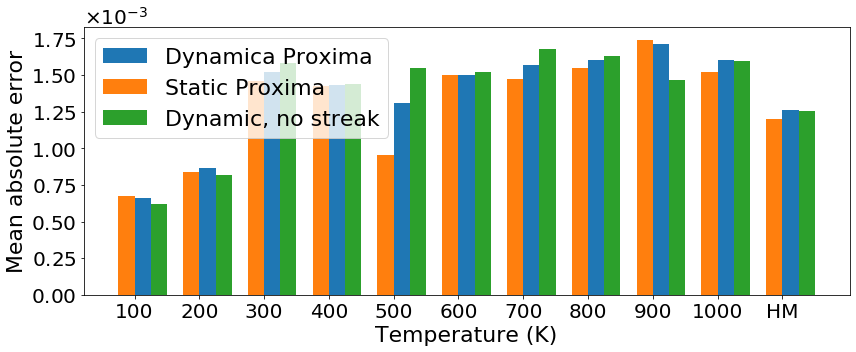

In [31]:
RI= True #set true or false depending on retrain interval usage
SS = False #Comparing with simple surrogate
labels = list(_temp_ssnort)

x = np.arange(len(labels))  # the label locations
fig, ax = plt.subplots(figsize=(FIGWIDTH,5))

rects1 = ax.bar(x + width/2, list(_mae_da), width, label='Dynamica Proxima')
rects2 = ax.bar(x - width/2, list(_mae_sa), width, label='Static Proxima')
rects4 = ax.bar(x + (width/2)+width, list(_mae_nostreak), width, label='Dynamic, no streak')
if SS:
    if RI:
        rects3 = ax.bar(x + (width/2)+width*2, list(_mae_ss300), width, label='Fixed, RI=300')
    else:
        rects3 = ax.bar(x + (width/2)+width*2, list(_mae_ssnort), width, label='Fixed, no RI')


# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Mean absolute error', fontsize=BIG)
ax.set_xlabel("Temperature (K)", fontsize=BIG)
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.yaxis.get_offset_text().set_fontsize(MEDIUM)
ax.ticklabel_format(axis='y', style='scientific', scilimits=(0,0), useMathText=True)
plt.xticks(fontsize=MEDIUM)
plt.yticks(fontsize=MEDIUM)
ax.legend(fontsize=BIG)
plt.tight_layout()
plt.savefig('Figures/3prox_MAEbar.pdf')

# 4) Speedup Bar Chart

In [32]:
def graph_values_speedup(name):
    _t_sa = results[name]['time']
    _speedup_sa = results[name]['speed_up']
    _temp_sa = results[name]['temperature']
   
    _temp_sa, _t_sa, _speedup_sa = zip(*sorted(zip(_temp_sa, _t_sa,_speedup_sa)))
    hm_sp_sa = stat.harmonic_mean(_speedup_sa)
    hm_t_sa = stat.harmonic_mean(_t_sa)
    _speedup_sa = _speedup_sa + (hm_sp_sa,)
    _t_sa = _t_sa + (hm_t_sa,)
    _temp_sa = _temp_sa + ('HM',)
    return _speedup_sa,_t_sa, _temp_sa
    
_speedup_sa,_t_sa,_temp_sa = graph_values_speedup("NORT-Proxima_static-alpha")
_speedup_da,_t_da,_temp_da = graph_values_speedup("NORT-Proxima_dynamicalpha")
_speedup_ssnort,_t_ssnort, _temp_ssnort = graph_values_speedup("SS-UQ02-NORT_staticalpha")
_speedup_ss,_t_ss,_temp_ss = graph_values_speedup("SS-UQ02_I50")
_speedup_ss300,_t_ss300,_temp_ss300 = graph_values_speedup("SS_RI300")
_speedup_nostreak, _t_nostreak, _temp_nostreak = graph_values_speedup("dyn_nostreak")

## Graphing Speed-up Comparison: Dynamic vs Simple Surrogate No Retrain Interval 
Simple surrogate uses UQ: 0.2

In [33]:
def graph_speedup(RI, _speedup_da, _speedup_sa, _speedup_ss300, _speedup_ssnort):
    labels = list(_temp_ssnort)

    x = np.arange(len(labels))  # the label locations
    fig, ax = plt.subplots(figsize=(FIGWIDTH,5))

    rects1 = ax.bar(x + width/2, list(_speedup_da), width, label='Dynamica Proxima')
    rects2 = ax.bar(x - width/2, list(_speedup_sa), width, label='Static Proxima')
    if RI:
        rects3 = ax.bar(x + (width/2)+width, list(_speedup_ss300), width, label='Fixed, RI=300')
    else:
        rects3 = ax.bar(x + (width/2)+width, list(_speedup_ssnort), width, label='Fixed, no RI')

    ax.set_ylabel('Speedup', fontsize=BIG)
    ax.set_xlabel('Temperature (K)', fontsize=BIG)
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    plt.xticks(fontsize=MEDIUM)
    plt.yticks(fontsize=MEDIUM)
    ax.legend(fontsize=BIG)
    plt.tight_layout()

    if RI:
        plt.savefig('Figures/speedup_best.pdf')
    else:
        plt.savefig('Figures/nort_speedup_bar.pdf')

    plt.show()

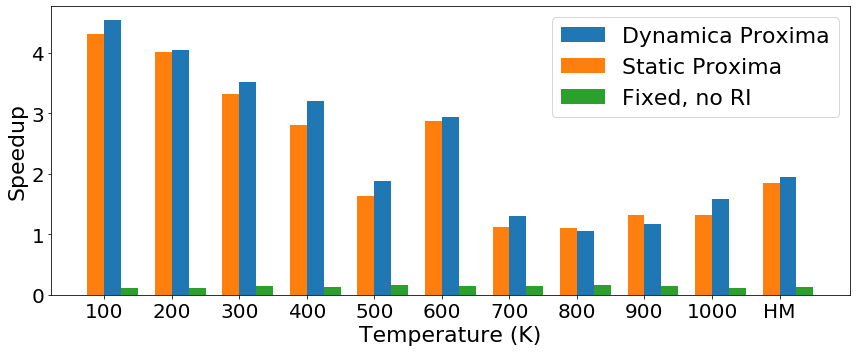

In [34]:
graph_speedup(False, _speedup_da, _speedup_sa, _speedup_ss300, _speedup_ssnort)

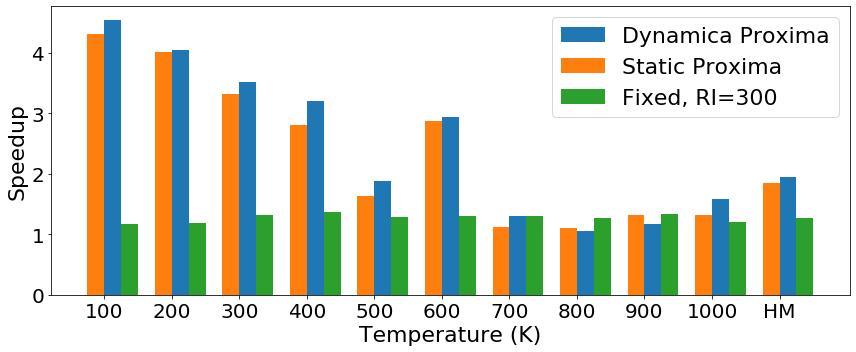

In [35]:
graph_speedup(True, _speedup_da, _speedup_sa, _speedup_ss300, _speedup_ssnort)

## Dynamic, Static, No streak VS SS with RI 300

In [36]:
def graph_more_speedup(RI, SS, _speedup_da, _speedup_sa, _speedup_ss300, _speedup_ssnort):
    labels = list(_temp_ssnort)

    x = np.arange(len(labels))  # the label locations
    fig, ax = plt.subplots(figsize=(FIGWIDTH,5))

    rects1 = ax.bar(x + width/2, list(_speedup_da), width, label='Dynamica Proxima')
    rects2 = ax.bar(x - width/2, list(_speedup_sa), width, label='Static Proxima')
    rects4 = ax.bar(x + (width/2)+width, list(_speedup_nostreak), width, label='Dynamic, no streak')
    if SS:
        if RI:
            rects3 = ax.bar(x + (width/2)+width*2, list(_speedup_ss300), width, label='Fixed, RI=300')
        else:
            rects3 = ax.bar(x + (width/2)+width*2, list(_speedup_ssnort), width, label='Fixed, no RI')

    ax.set_ylabel('Speed-up', fontsize=BIG)
    ax.set_xlabel('Temperature (K)', fontsize=BIG)
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    plt.xticks(fontsize=MEDIUM)
    plt.yticks(fontsize=MEDIUM)
    ax.legend(fontsize=BIG)
    plt.tight_layout()
    
    plt.savefig('Figures/3prox_speedupbar.pdf')
    plt.show()

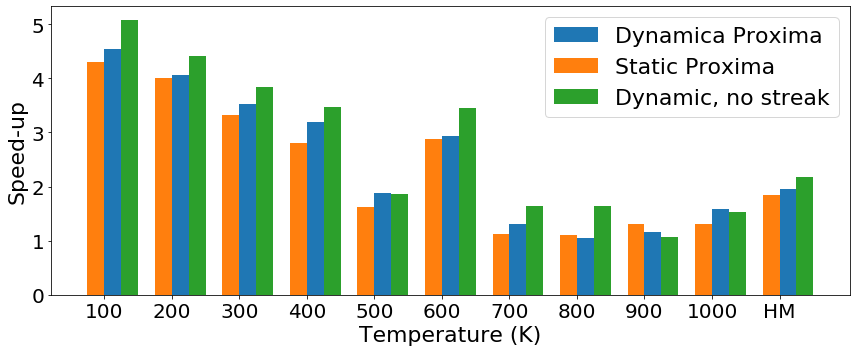

In [37]:
graph_more_speedup(True, False, _speedup_da, _speedup_sa, _speedup_ss300, _speedup_ssnort)

### Graphing Speed-up Comparison: Dynamic, NO surrogate streak vs Simple Surrogate with 300 RI
Simple surrogate uses UQ: 0.2

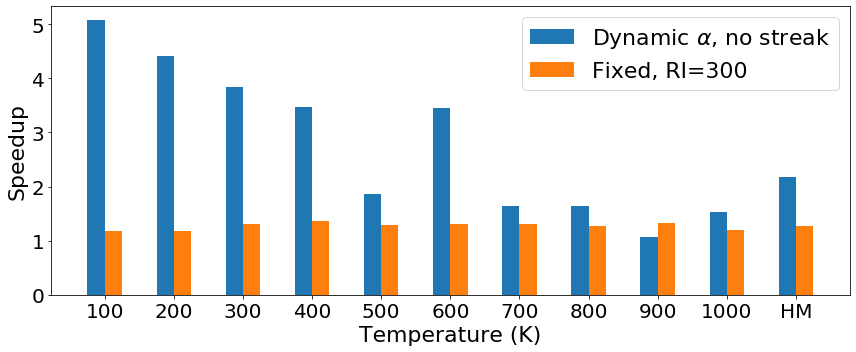

In [38]:
labels = list(_temp_ssnort)

x = np.arange(len(labels))  # the label locations
fig, ax = plt.subplots(figsize=(FIGWIDTH,5))
rects1 = ax.bar(x - width/2, list(_speedup_nostreak), width, label=r'Dynamic $\alpha$, no streak')
rects2 = ax.bar(x + width/2, list(_speedup_ss300), width, label='Fixed, RI=300')

ax.set_ylabel('Speedup', fontsize=BIG)
ax.set_xlabel('Temperature (K)', fontsize=BIG)
ax.set_xticks(x)
ax.set_xticklabels(labels)
plt.xticks(fontsize=MEDIUM)
plt.yticks(fontsize=MEDIUM)
ax.legend(fontsize=BIG)
plt.tight_layout()

plt.savefig('Figures/nostreak_ss_bar.pdf')
plt.show()

## Graphing Speed-up Comparison: Dynamic vs Simple Surrogate with 300 RI
Simple surrogate uses UQ: 0.2

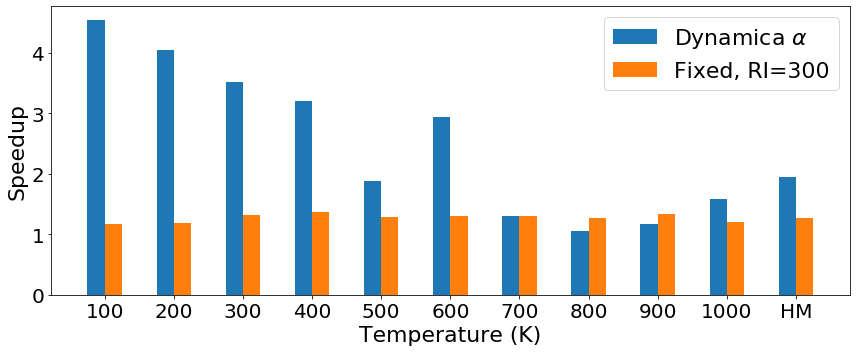

In [39]:
labels = list(_temp_ssnort)

x = np.arange(len(labels))  # the label locations
fig, ax = plt.subplots(figsize=(FIGWIDTH,5))
rects1 = ax.bar(x - width/2, list(_speedup_da), width, label=r'Dynamica $\alpha$')
rects2 = ax.bar(x + width/2, list(_speedup_ss300), width, label='Fixed, RI=300')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Speedup', fontsize=BIG)
ax.set_xticks(x)
ax.set_xlabel('Temperature (K)', fontsize=BIG)
ax.set_xticklabels(labels)
plt.xticks(fontsize=MEDIUM)
plt.yticks(fontsize=MEDIUM)
ax.legend(fontsize=BIG)
plt.tight_layout()

plt.savefig('Figures/speedup_best300.pdf')
plt.show()

## Graphing Time Comparison: Dynamic vs Static Proxima

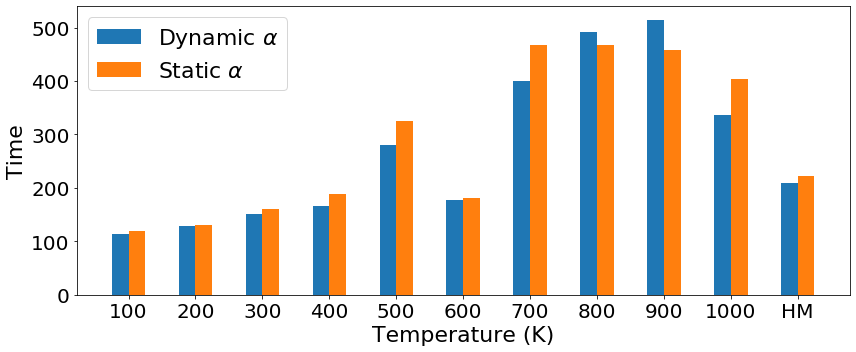

In [40]:
labels = list(_temp_sa)

x = np.arange(len(labels))  # the label locations
fig, ax = plt.subplots(figsize=(FIGWIDTH,5))

rects1 = ax.bar(x - width/2, list(_t_da), width, label=r'Dynamic $\alpha$')
rects2 = ax.bar(x + width/2, list(_t_sa), width, label=r'Static $\alpha$')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Time', fontsize=BIG)
ax.set_xlabel('Temperature (K)', fontsize=BIG)
ax.set_xticks(x)
ax.set_xticklabels(labels)
plt.xticks(fontsize=MEDIUM)
plt.yticks(fontsize=MEDIUM)
ax.legend(fontsize=BIG)
plt.tight_layout()

plt.show()

## Graphing Speed-up: Dynamic vs Static Proxima

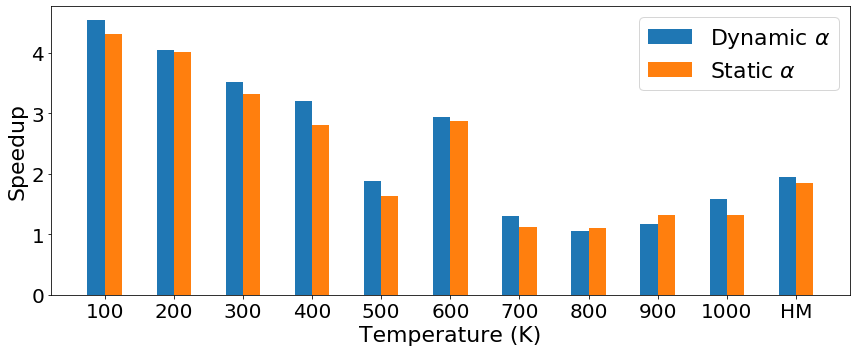

In [41]:
labels = list(_temp_sa)

x = np.arange(len(labels))  # the label locations
fig, ax = plt.subplots(figsize=(FIGWIDTH,5))

rects1 = ax.bar(x - width/2, list(_speedup_da), width, label=r'Dynamic $\alpha$') # r'$\sin (x)$'
rects2 = ax.bar(x + width/2, list(_speedup_sa), width, label=r'Static $\alpha$')

ax.set_ylabel('Speedup', fontsize=BIG)
ax.set_xlabel('Temperature (K)', fontsize=BIG)
ax.set_xticks(x)
ax.set_xticklabels(labels)
plt.xticks(fontsize=MEDIUM)
plt.yticks(fontsize=MEDIUM)
ax.legend(fontsize=BIG)
plt.tight_layout()

plt.show()

## Function to graph cases - only works with two cases

In [42]:
def _plot_cases2(cases):
    fig, ax = plt.subplots(figsize=(FIGWIDTH,5))
    num_case = len(cases)
    total_width = 0.7
    #width total_width / num_case
    for i in range(num_case):
        case = cases[i]
        x_offset = (i - num_case / 2) * width + width / 2
        labels = list(case.get('df'))
        x = np.arange(len(labels))  # the label locations
        y = case.get('y')
        label = case.get('label')
        rects1 = ax.bar(x + x_offset, list(y), width, label=label)

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Time', fontsize=BIG)
    ax.set_xlabel('Temperature (K)', fontsize=BIG)
    ax.set_xticks(x)
    ax.set_xticklabels(labels, fontsize=MEDIUM)
    plt.xticks(fontsize=MEDIUM)
    plt.yticks(fontsize=MEDIUM)
    ax.legend(fontsize=BIG)

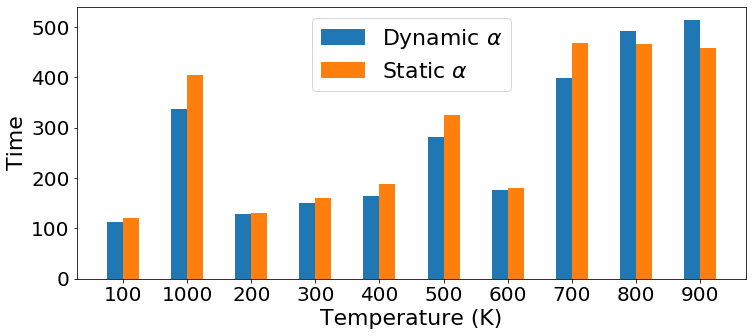

In [43]:
cases = (
        {"df": results["NORT-Proxima_dynamicalpha"]['temperature'],'y': results["NORT-Proxima_dynamicalpha"]['time'],"label":r'Dynamic $\alpha$', "marker":"x"},
        {"df": results["NORT-Proxima_static-alpha"]['temperature'],'y': results["NORT-Proxima_static-alpha"]['time'],"label":r'Static $\alpha$', "marker":"x"},
        #{"df": results["SS-UQ02-NORT_staticalpha"]['temperature'],'y': results["surrogate_only"]['time'],"label":'Fixed', "marker":"x"},
    )
_plot_cases2(cases)